In [1]:
import pandas as pd
import numpy as np
from data_preprocess import Data

pop_df = Data.get_pop_df()
pop_df.head(5)

Using cached file: data\WPP2024_Demographic_Indicators_Medium.csv.gz


,Time,ISO2_code,Population
0,1970,BI,3487370
1,1971,BI,3573495
2,1972,BI,3661084
3,1973,BI,3573171
4,1974,BI,3650811


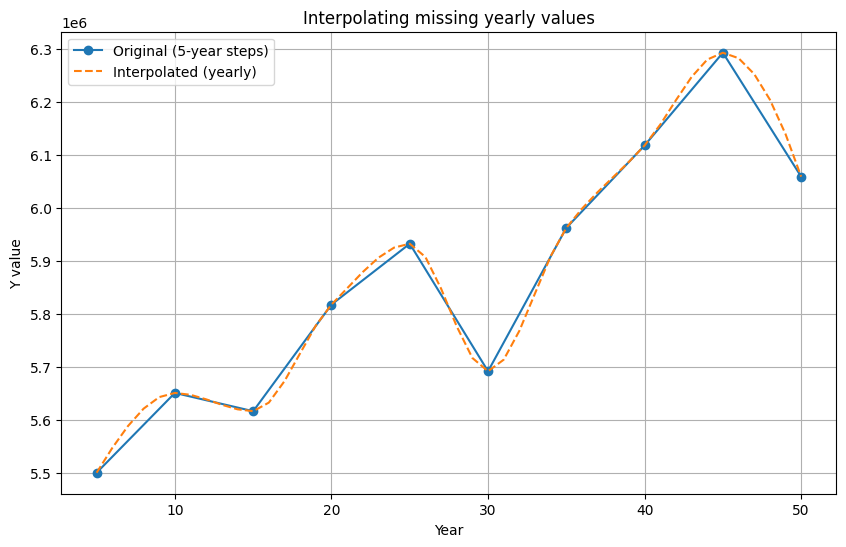

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

def solve_missing_values(y, x):
    all_years = np.arange(min(x), max(x) + 1, 1)
    interp = PchipInterpolator(x, y)
    return interp(all_years), all_years

n = 10
start_val = 5.5 * 10**6
x = list(range(5, 55, 5))  # [5, 10, ..., 50]

# Generate values with ±5% change
y = [start_val]
rng = np.random.default_rng(seed=42)  # reproducible random numbers
for _ in range(n - 1):
    change_factor = 1 + rng.uniform(-0.05, 0.05)  # between -5% and +5%
    y.append(y[-1] * change_factor)

# Example data (replace with your own)

y_smooth, all_years = solve_missing_values(y, x)

# Plot
plt.figure(figsize=(10,6))
plt.plot(x, y, "o-", label="Original (5-year steps)")
plt.plot(all_years, y_smooth, "--", label="Interpolated (yearly)")
plt.xlabel("Year")
plt.ylabel("Y value")
plt.title("Interpolating missing yearly values")
plt.legend()
plt.grid(True)
plt.show()


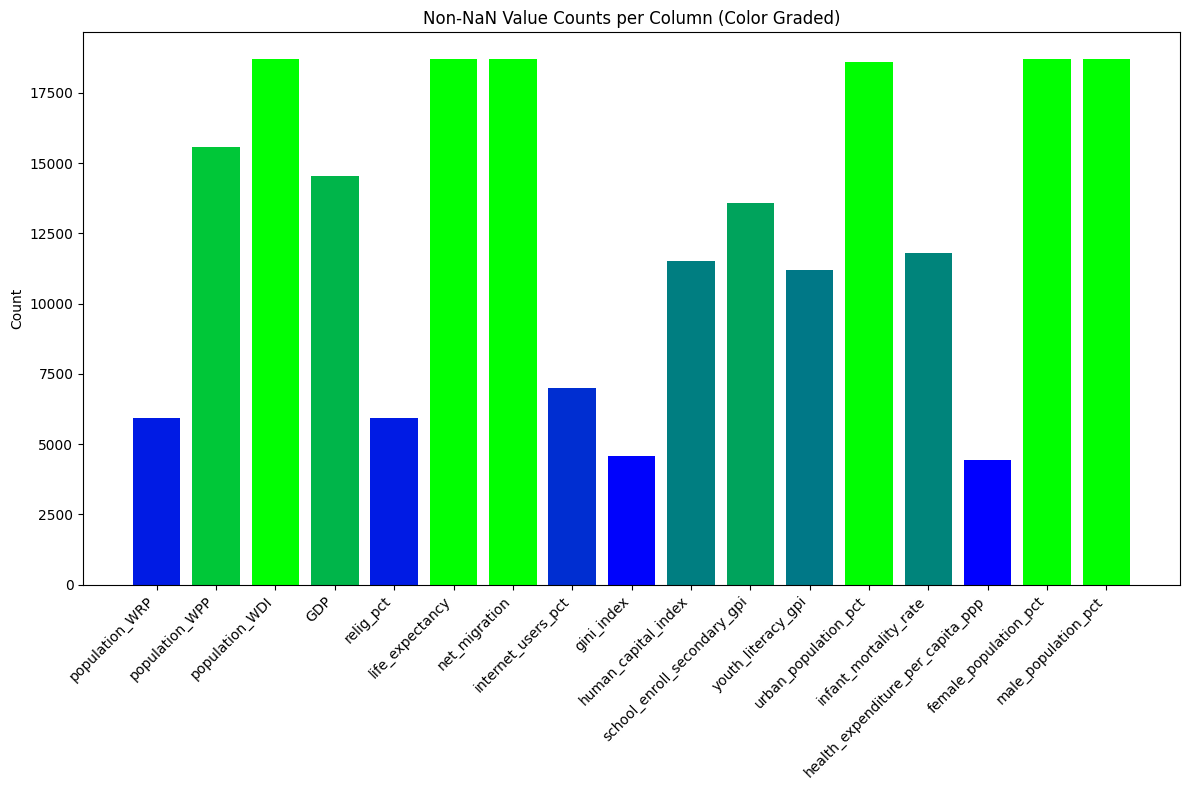

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
df = pd.read_csv("data\\cleaned_all_data.csv")

rename_map = {
    'Fertility rate, total (births per woman) [SP.DYN.TFRT.IN]': 'fertility_rate',
    'Birth rate, crude (per 1,000 people) [SP.DYN.CBRT.IN]': 'birth_rate',
    'Death rate, crude (per 1,000 people) [SP.DYN.CDRT.IN]': 'death_rate',
    'Life expectancy at birth, total (years) [SP.DYN.LE00.IN]': 'life_expectancy',
    'Net migration [SM.POP.NETM]': 'net_migration',
    'Individuals using the Internet (% of population) [IT.NET.USER.ZS]': 'internet_users_pct',
    'Gini index [SI.POV.GINI]': 'gini_index',
    'Human capital index (HCI) (scale 0-1) [HD.HCI.OVRL]': 'human_capital_index',
    'School enrollment, secondary (gross), gender parity index (GPI) [SE.ENR.SECO.FM.ZS]': 'school_enroll_secondary_gpi',
    'Literacy rate, youth (ages 15-24), gender parity index (GPI) [SE.ADT.1524.LT.FM.ZS]': 'youth_literacy_gpi',
    'Urban population (% of total population) [SP.URB.TOTL.IN.ZS]': 'urban_population_pct',
    'Mortality rate, infant (per 1,000 live births) [SP.DYN.IMRT.IN]': 'infant_mortality_rate',
    'Current health expenditure per capita, PPP (current international $) [SH.XPD.CHEX.PP.CD]': 'health_expenditure_per_capita_ppp',
    'Population, female (% of total population) [SP.POP.TOTL.FE.ZS]': 'female_population_pct',
    'Population, male (% of total population) [SP.POP.TOTL.MA.ZS]': 'male_population_pct',
    'Population, total [SP.POP.TOTL]': 'population_WDI',
    'pop': 'population_WRP',
    'population': 'population_WPP',
}

relig_cols = ["christian", "islam", "buddhist", "judaism", "other"]

# Require all values present, otherwise NaN
df["relig_pct"] = df[relig_cols].sum(axis=1, skipna=False)

# Drop old columns
df.drop(columns=relig_cols, inplace=True)

columns_of_interest = [
    'name',
    'alpha_2',
    'year',
    'population_WRP',
    'population_WPP',
    'population_WDI',
    'GDP',
    'relig_pct',
    'life_expectancy',
    'net_migration',
    'internet_users_pct',
    'gini_index',
    'human_capital_index',
    'school_enroll_secondary_gpi',
    'youth_literacy_gpi',
    'urban_population_pct',
    'infant_mortality_rate',
    'health_expenditure_per_capita_ppp',
    'female_population_pct',
    'male_population_pct',
    ]
df.rename(columns=rename_map, inplace=True)
df = df[[col for col in columns_of_interest if col in df.columns]]


# Exclude the first five columns
excluded_columns = df.columns[:3]
df_remaining = df.drop(columns=excluded_columns)

# Count non-NaN values per remaining column
non_nan_counts = df_remaining.notna().sum()

# Normalize values for color mapping (0 to 1 scale)
norm = (non_nan_counts - non_nan_counts.min()) / (non_nan_counts.max() - non_nan_counts.min())

# Create colors: from blue (low) to green (high)
colors = [(0, n, 1 - n) for n in norm]  # RGB tuples: blue to green

# Plot
plt.figure(figsize=(12, 8))
bars = plt.bar(non_nan_counts.index, non_nan_counts.values, color=colors)
plt.title("Non-NaN Value Counts per Column (Color Graded)")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
# import numpy as np

# pop_cols = ["population_WRP", "population_WPP", "population_WDI"]

# def fill_populations(row):
#     values = row[pop_cols].dropna().values
    
#     # Case 1: only one value present → fill others with that value
#     if len(values) == 1:
#         return pd.Series([values[0]] * 3, index=pop_cols)
    
#     # Case 2: two values present → fill missing one with max of the two
#     elif len(values) == 2:
#         fill_val = max(values)
#         return row[pop_cols].where(row[pop_cols].notna(), fill_val)
    
#     # Case 3: all three present → leave as is
#     else:
#         return row[pop_cols]

# # Apply row-wise
# df[pop_cols] = df.apply(fill_populations, axis=1)


In [45]:
pop_cols = ["population_WRP", "population_WPP", "population_WDI"]

# Compute relative difference between max and min across sources
df["pop_rel_diff"] = (
    df[pop_cols].max(axis=1) - df[pop_cols].min(axis=1)
) / df[pop_cols].min(axis=1)

df_mismatch = df[df["pop_rel_diff"] > 0.20]
df_mismatch.shape


(402, 21)

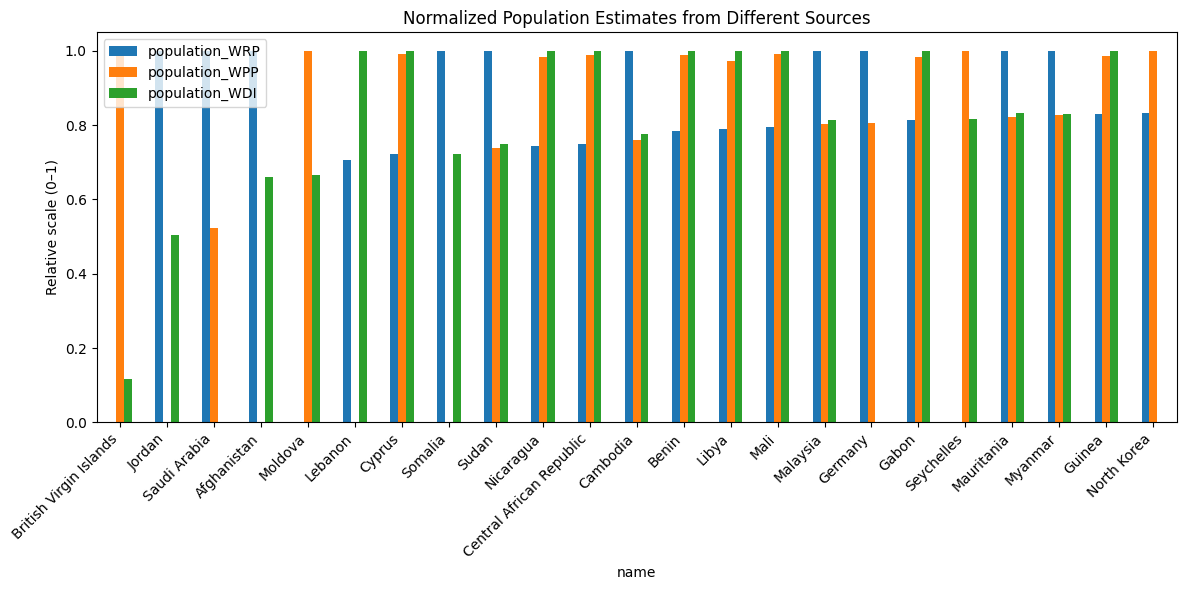

In [46]:
import matplotlib.pyplot as plt

# Pick top 10 mismatches (one per country)
subset = (
    df_mismatch.sort_values("pop_rel_diff", ascending=False)
    .drop_duplicates(subset="name", keep="first")
    .set_index("name")
)
# Normalize values row-wise (each country scaled 0–1)
subset_norm = subset[pop_cols].div(subset[pop_cols].max(axis=1), axis=0)

# Plot normalized
subset_norm.plot(kind="bar", figsize=(12,6))
plt.title("Normalized Population Estimates from Different Sources")
plt.ylabel("Relative scale (0–1)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


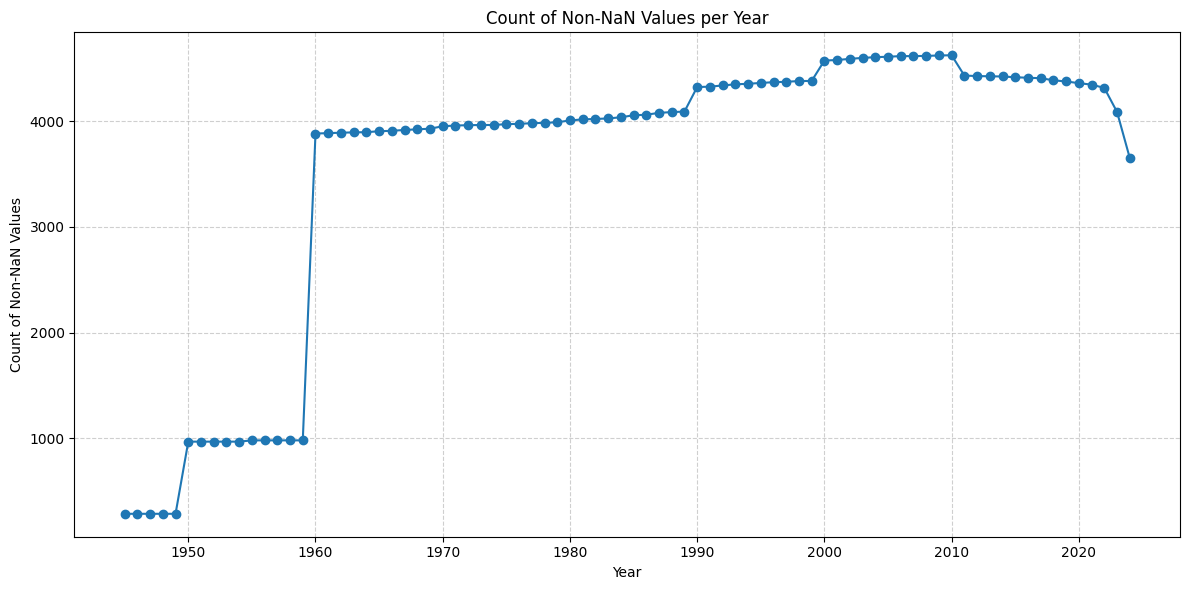

In [47]:
import matplotlib.pyplot as plt

# Count non-NaN rows for each year (across all columns except country_name)
year_counts = (
    df.drop(columns=["name"])     # drop non-numeric identifier column
      .notna()                            # True for non-NaN
      .groupby(df["year"])                # group by year
      .sum()                              # sum True values → count of non-NaNs per column
)

# Total non-NaN values per year across all columns
year_counts["total_non_nan"] = year_counts.sum(axis=1)

# Plot
plt.figure(figsize=(12,6))
plt.plot(year_counts.index, year_counts["total_non_nan"], marker="o")
plt.title("Count of Non-NaN Values per Year")
plt.xlabel("Year")
plt.ylabel("Count of Non-NaN Values")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


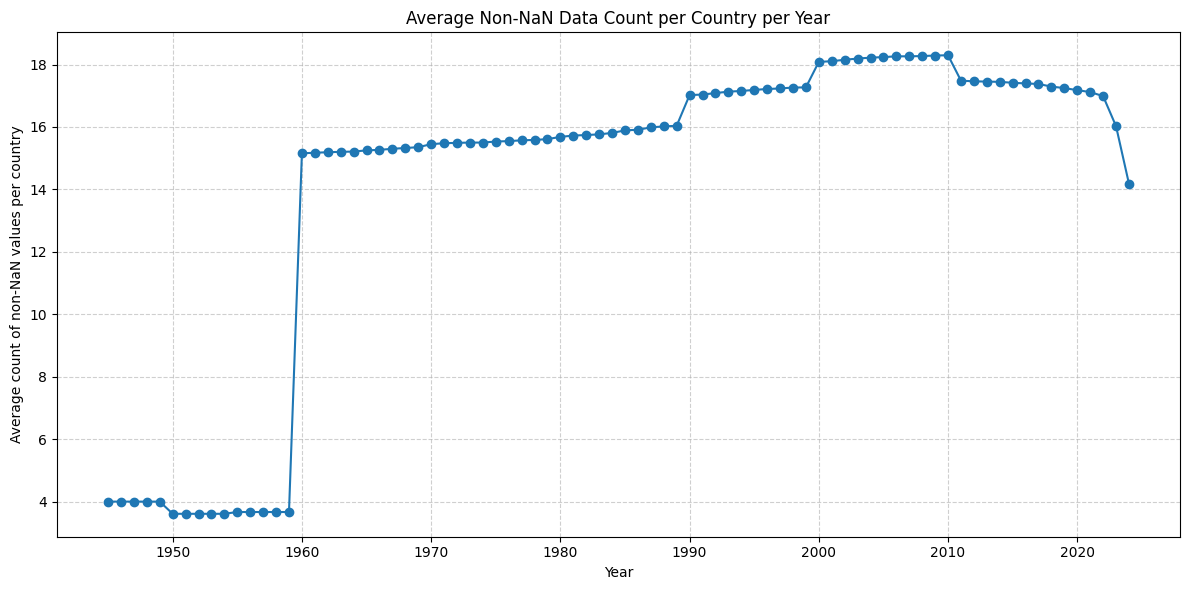

In [48]:
import matplotlib.pyplot as plt

# Exclude non-data columns
data_cols = [c for c in df.columns if c not in ["name", "year"]]

# Count non-NaN values per year per country
year_country_counts = (
    df.groupby("year")[data_cols]
      .apply(lambda g: g.notna().sum(axis=1))   # count non-nans per row
)

# Total non-NaN values per year
total_counts_per_year = year_country_counts.groupby("year").sum()

# Number of countries with at least one non-NaN value that year
countries_per_year = (
    df.groupby("year")["name"]
      .nunique()
)

# Average data count per country
average_data_count_per_country = total_counts_per_year / countries_per_year

# Plot
plt.figure(figsize=(12,6))
plt.plot(average_data_count_per_country.index,
         average_data_count_per_country.values,
         marker="o")

plt.title("Average Non-NaN Data Count per Country per Year")
plt.xlabel("Year")
plt.ylabel("Average count of non-NaN values per country")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


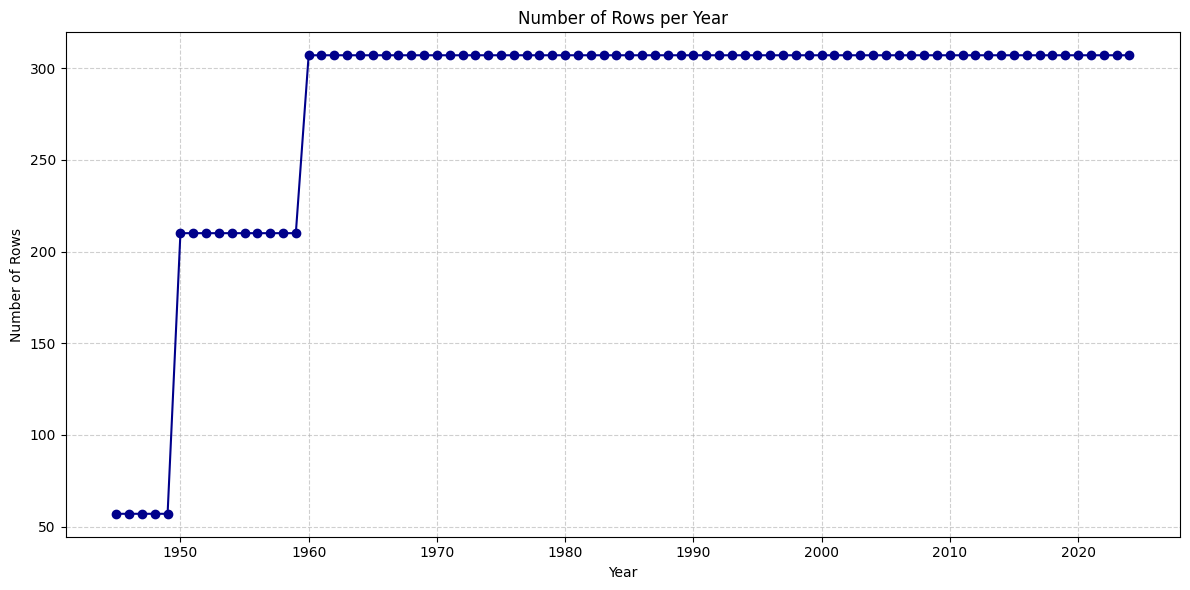

In [49]:
import matplotlib.pyplot as plt

# Count rows per year
rows_per_year = df.groupby("year").size()

# Plot
plt.figure(figsize=(12,6))
plt.plot(rows_per_year.index, rows_per_year.values, marker="o", color="darkblue")
plt.title("Number of Rows per Year")
plt.xlabel("Year")
plt.ylabel("Number of Rows")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


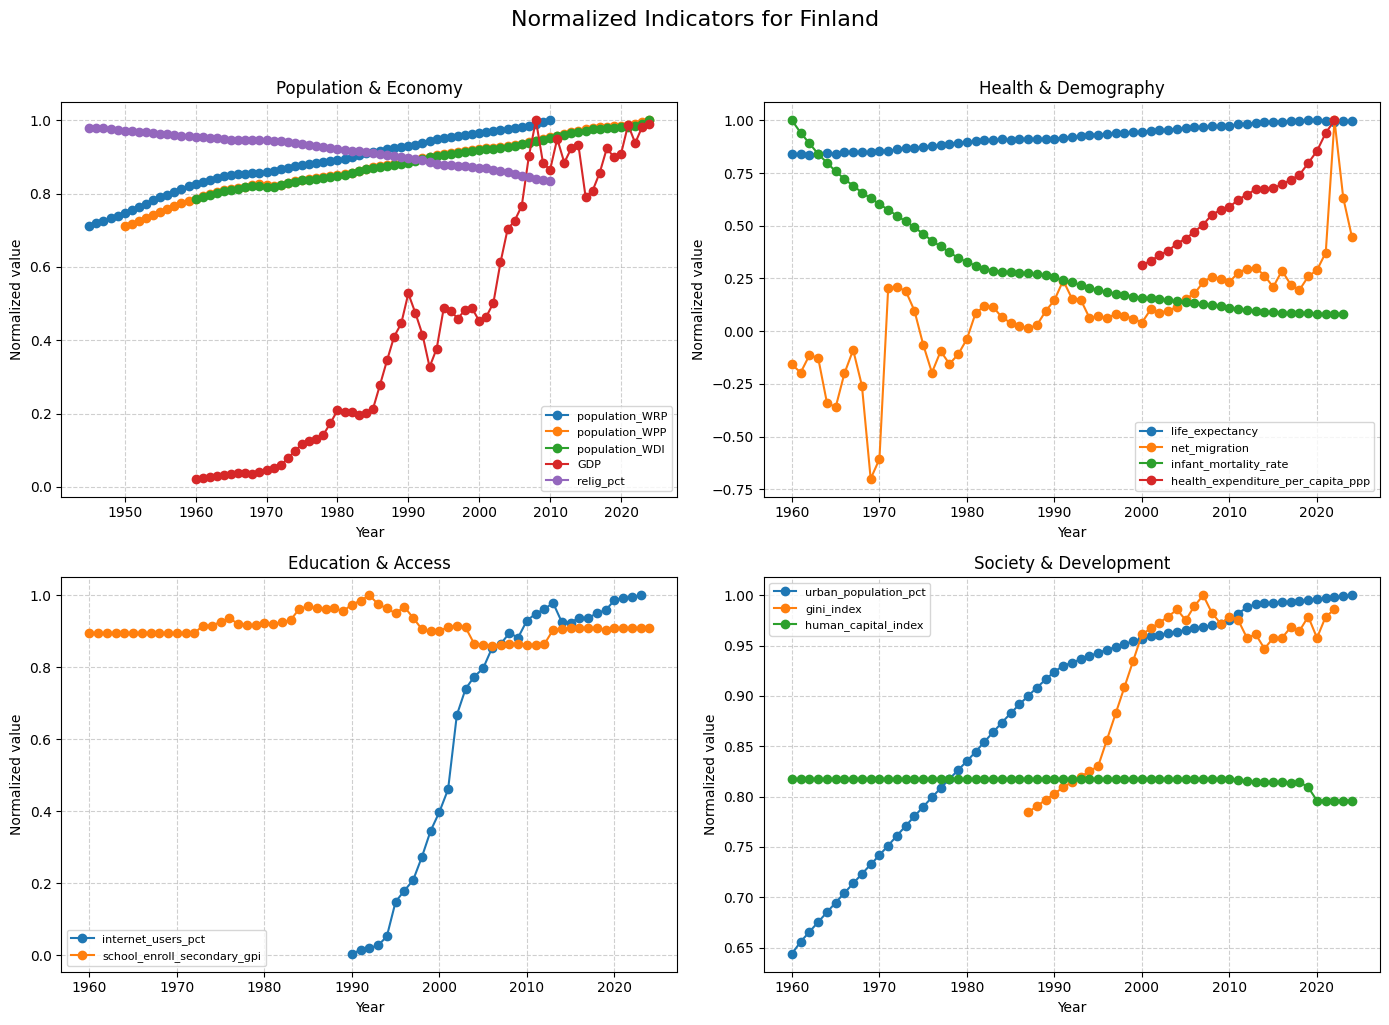

In [55]:
import matplotlib.pyplot as plt

def plot_country(country_name):
    # Select the country
    df_country = df[df["name"] == country_name].set_index("year")
    
    # Exclude non-numeric columns
    numeric_cols = df_country.select_dtypes(include=["number"])
    
    if numeric_cols.empty:
        print(f"No numeric data available for {country_name}")
        return
    
    # --- Normalization function ---
    def normalize_series(series):
        col_min, col_max = series.min(), series.max()
        if col_min >= 0 and col_max <= 1:  # already 0–1
            return series
        max_val = col_max if col_max != 0 else 1
        return series / max_val
    
    # Normalize all numeric columns
    normalized = numeric_cols.apply(normalize_series, axis=0)
    
    # --- Groups of columns for subplots ---
    groups = {
        "Population & Economy": [
            'population_WRP', 'population_WPP', 'population_WDI', 'GDP', 'relig_pct'
        ],
        "Health & Demography": [
            'life_expectancy', 'net_migration', 'infant_mortality_rate', 'health_expenditure_per_capita_ppp'
        ],
        "Education & Access": [
            'youth_literacy_gpi', 'internet_users_pct', 'school_enroll_secondary_gpi'
        ],
        "Society & Development": [
            'urban_population_pct', 'gini_index', 'human_capital_index'
        ]
    }
    
    # --- Plot ---
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for ax, (title, cols) in zip(axes, groups.items()):
        subset = normalized[cols].dropna(axis=1, how="all")
        for col in subset.columns:
            ax.plot(subset.index, subset[col], marker="o", label=col)
        ax.set_title(title)
        ax.set_xlabel("Year")
        ax.set_ylabel("Normalized value")
        ax.legend(fontsize=8)
        ax.grid(True, linestyle="--", alpha=0.6)
    
    fig.suptitle(f"Normalized Indicators for {country_name}", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
plot_country("Finland")
